<a href="https://colab.research.google.com/github/alejandracardonavelasco/ML-/blob/main/Lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Lab 12**

These are the 10 classes of semantically related word pairs that I am going to use for this assignment:

**Class 1: Gender**
- (king, queen)
- (man, woman)
- (doctor, nurse)
- (prince, princess)
- (husband, wife)

**Class 2: Verb tense (past tense)**
- (bring, brought)
- (get, got)
- (like, liked)
- (play, played)
- (drink, drank)

**Class 3: Singular/plural**
- (cat, cats)
- (picture, pictures)
- (house, houses)
- (country, countries)
- (child, children)

**Class 4: Country/capital**
- (China, Pekin)
- (Thailand, Bangkok)
- (France, Paris)
- (Hungary, Budapest)
- (Germany, Berlin)

**Class 5: Comparative/superlative**
- (bigger,	biggest)
- (stronger,	strongest)
- (smarter,	smartest)
- (taller, tallest)
- (quicker, quickest)

**Class 6: Tool/user**
- (microphone, singer)
- (brush, painter)
- (camera, photographer)
- (pen, writer)
- (hammer, carpenter)

**Class 7: Animal/habitat**
- (lion, savannah)
- (camel, desert)
- (frog, swamp)
- (bear, forest)
- (fish, ocean)

**Class 8: Adjective/noun**
- (beautiful, beauty)
- (strong, strength)
- (kind, kindess)
- (dark, darkness)
- (happy, happiness)

**Class 9: Currency/country**
- (euro, Spain)
- (zloty, Poland)
- (dollar, USA)
- (pound, UK)
- (yen, Japan)

**Class 10: Job/place**
- (teacher, school)
- (surgeon, hospital)
- (chef, kitchen)
- (pilot, airport)
- (librarian, library)

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model (lowercased uncased BERT)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Semantic classes and word pairs
semantic_classes = {
    "Gender": [
        ("king", "queen"), ("man", "woman"), ("doctor", "nurse"),
        ("prince", "princess"), ("husband", "wife")
    ],
    "VerbTense": [
        ("bring", "brought"), ("get", "got"), ("like", "liked"),
        ("play", "played"), ("drink", "drank")
    ],
    "SingularPlural": [
        ("cat", "cats"), ("picture", "pictures"), ("house", "houses"),
        ("country", "countries"), ("child", "children")
    ],
    "CountryCapital": [
        ("china", "pekin"), ("thailand", "bangkok"), ("france", "paris"),
        ("hungary", "budapest"), ("germany", "berlin")
    ],
    "ComparativeSuperlative": [
        ("bigger", "biggest"), ("stronger", "strongest"),
        ("smarter", "smartest"), ("taller", "tallest"), ("quicker", "quickest")
    ],
    "ToolUser": [
        ("microphone", "singer"), ("brush", "painter"),
        ("camera", "photographer"), ("pen", "writer"), ("hammer", "carpenter")
    ],
    "AnimalHabitat": [
       ("lion", "savannah"), ("camel", "desert"), ("frog", "swamp"),
       ("bear", "forest"), ("fish", "ocean")
    ],

    "AdjectiveNoun": [
        ("beautiful", "beauty"), ("strong", "strength"), ("kind", "kindness"),
        ("dark", "darkness"), ("happy", "happiness")
    ],
    "CurrencyCountry": [
        ("euro", "spain"), ("zloty", "poland"), ("dollar", "usa"),
        ("pound", "uk"), ("yen", "japan")
    ],
    "JobPlace": [
        ("teacher", "school"), ("surgeon", "hospital"), ("chef", "kitchen"),
        ("pilot", "airport"), ("librarian", "library")
    ]
}

# Flatten list of all unique words
unique_words = sorted(set(word for pairs in semantic_classes.values() for pair in pairs for word in pair))

# Create a dictionary to hold embeddings
embedding_dict = {}

# Get embeddings for each word
with torch.no_grad():
    for word in unique_words:
        inputs = tokenizer(word, return_tensors="pt")
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state  # (1, seq_len, hidden_size)
        embedding = last_hidden_state[0].mean(dim=0)   # Average token embeddings
        embedding_dict[word] = embedding.numpy()

# Run PCA on all embeddings
all_vectors = [embedding_dict[word] for word in unique_words]
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_vectors)

# Build dataframe for global visualization
data = []
for word, coords in zip(unique_words, reduced):
    for class_name, pairs in semantic_classes.items():
        if any(word in pair for pair in pairs):
            data.append({
                "word": word,
                "x": coords[0],
                "y": coords[1],
                "class": class_name
            })
            break

df_all = pd.DataFrame(data)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

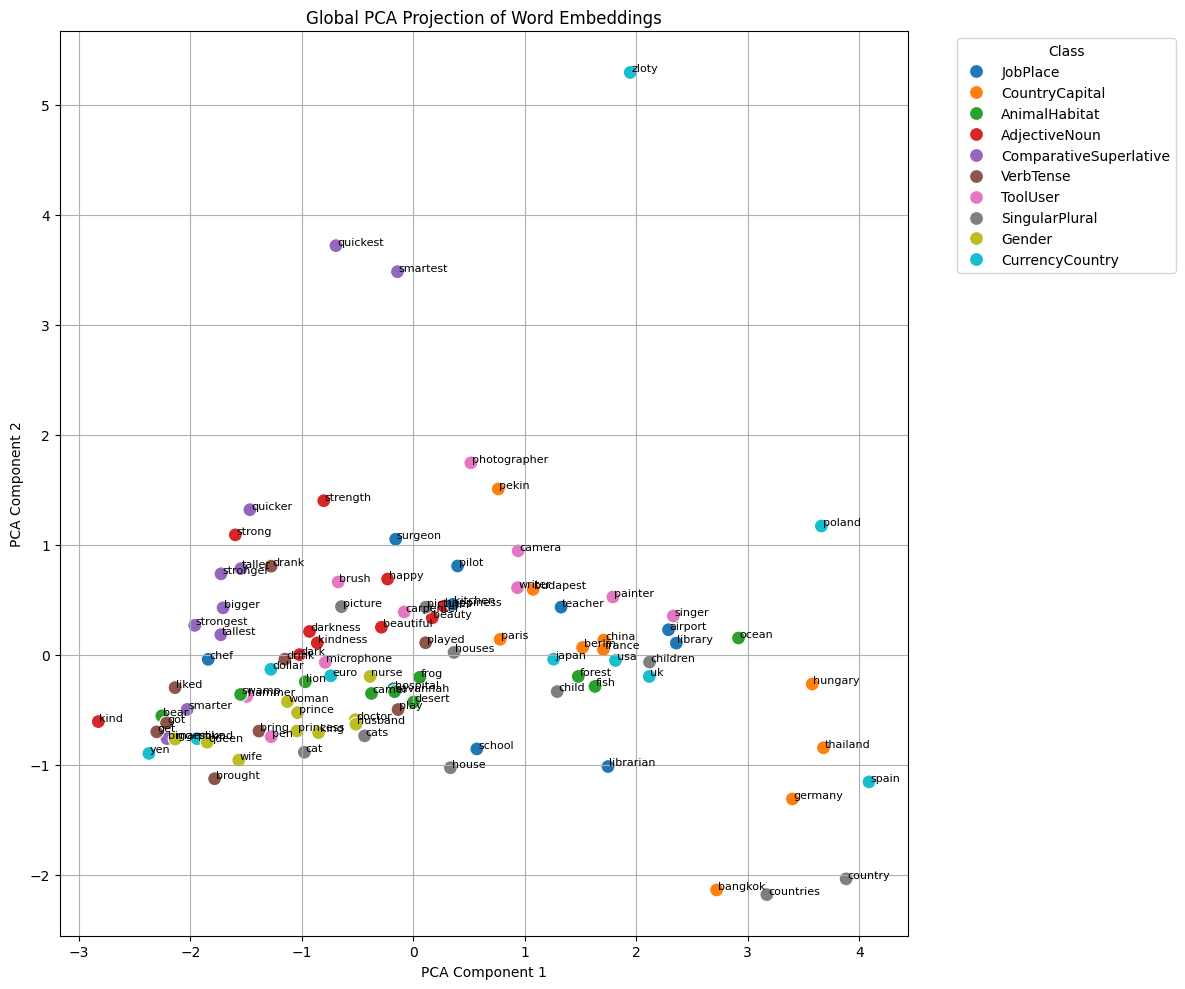

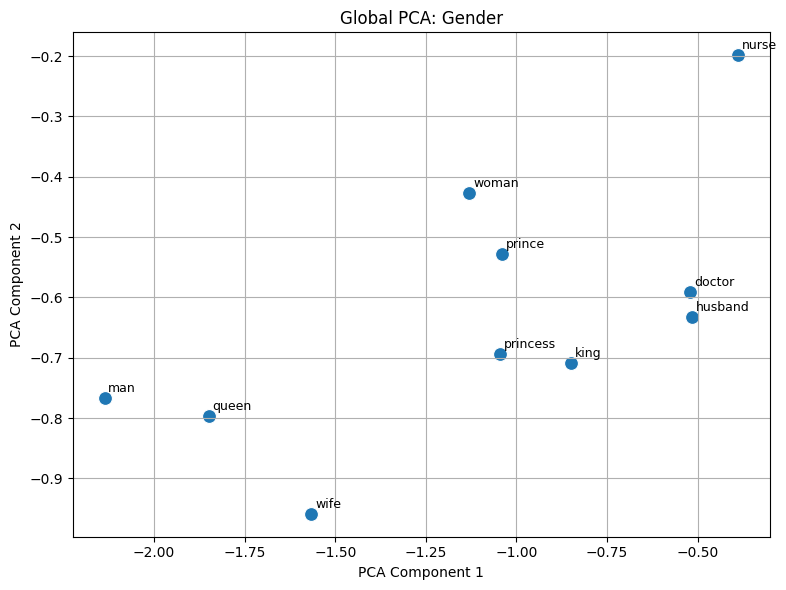

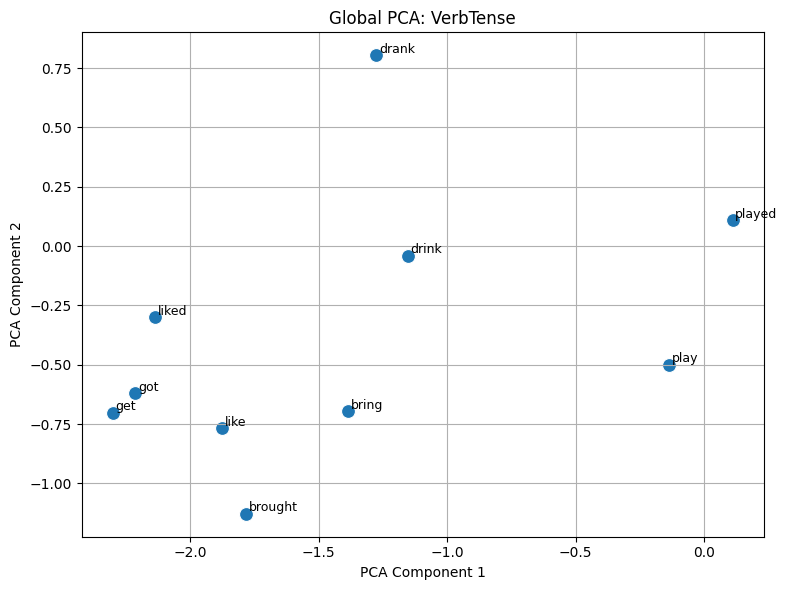

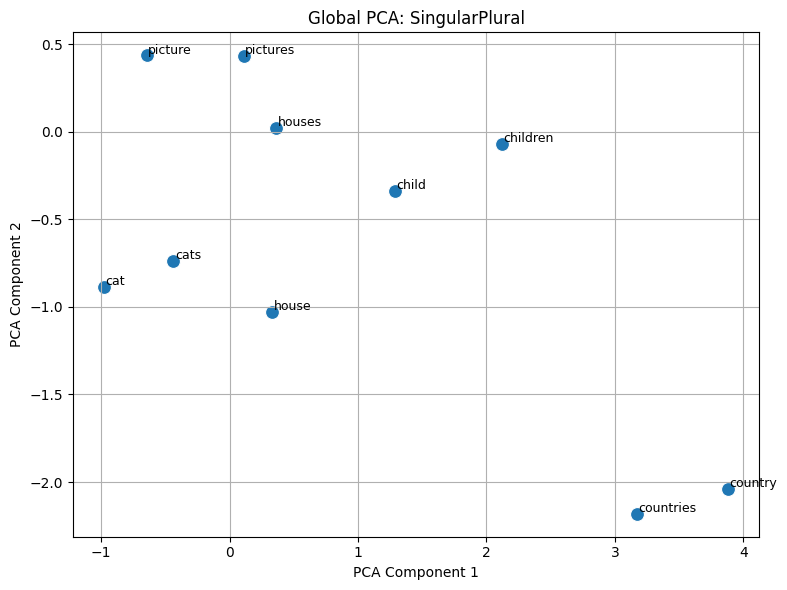

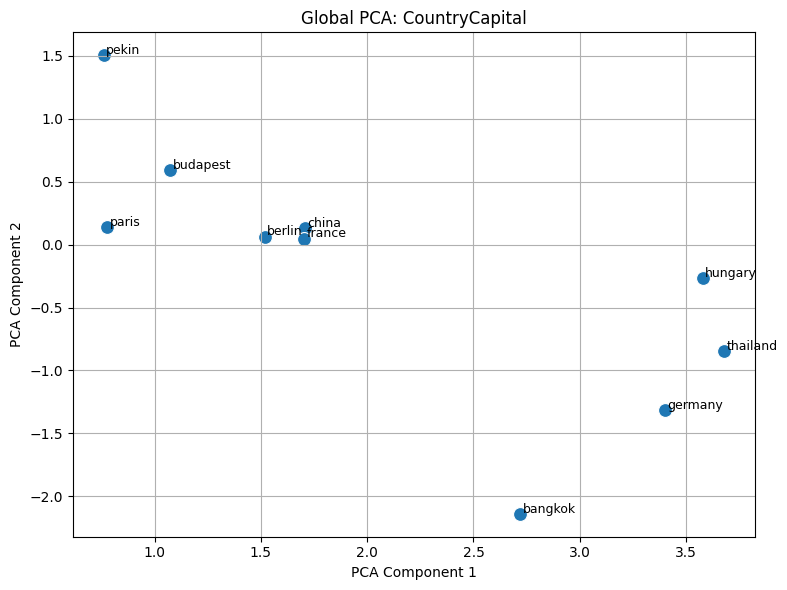

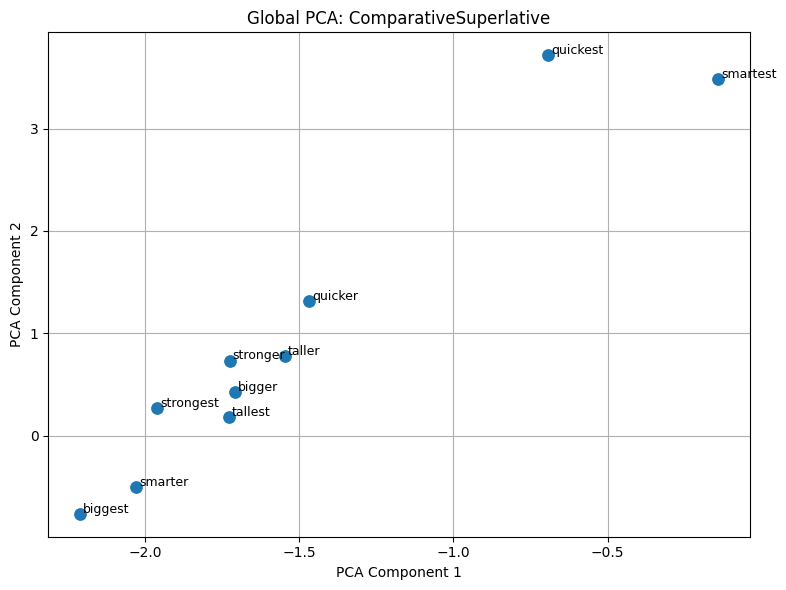

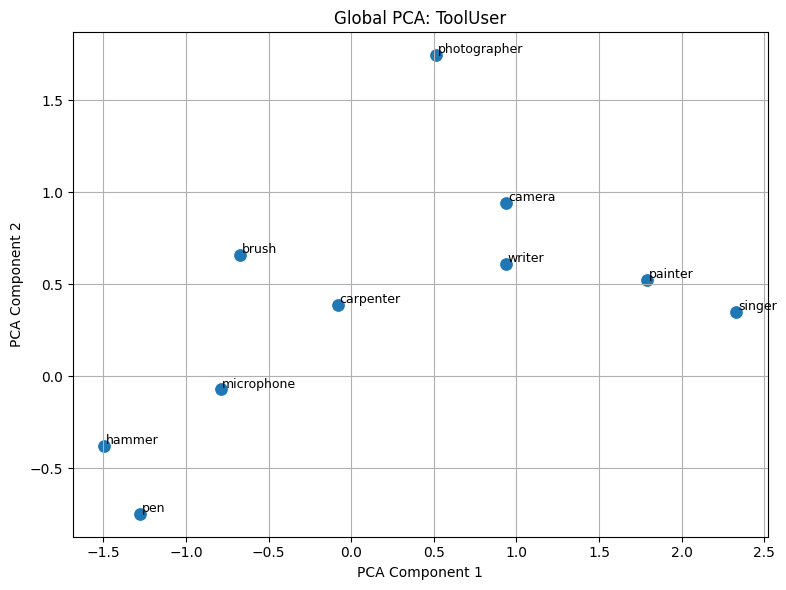

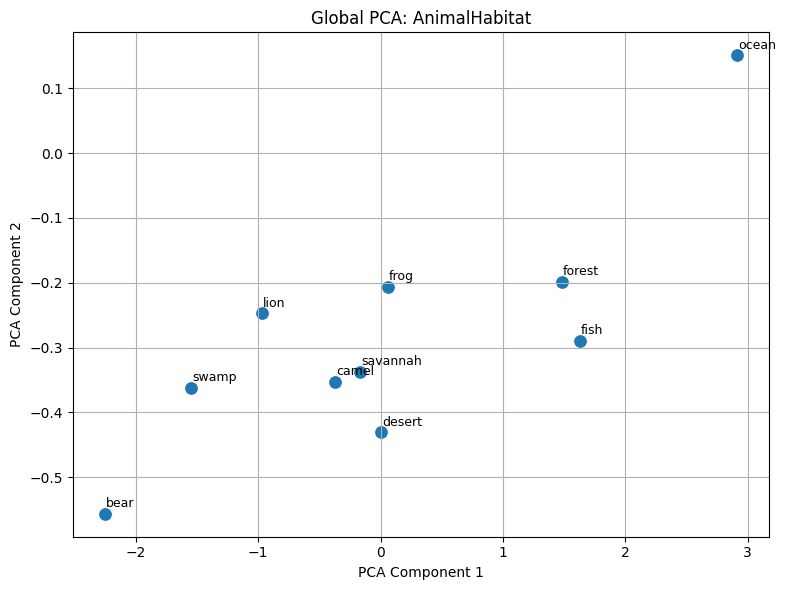

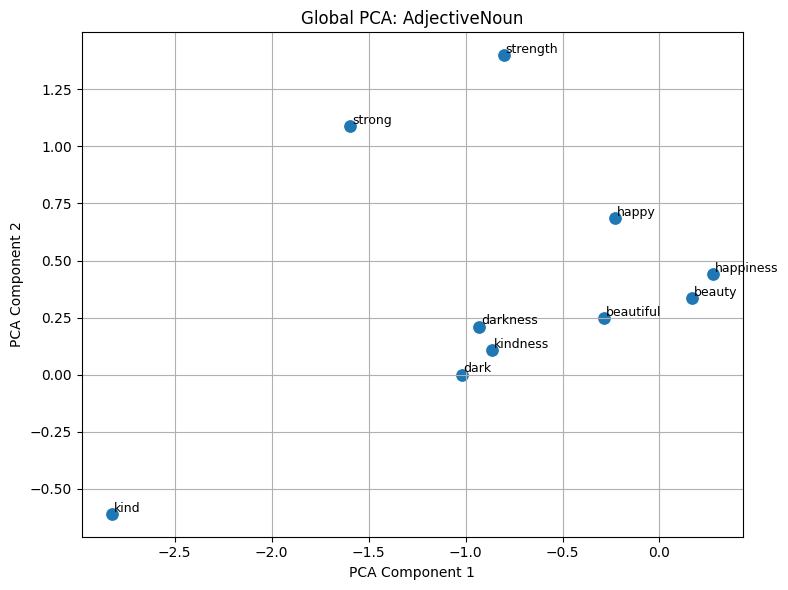

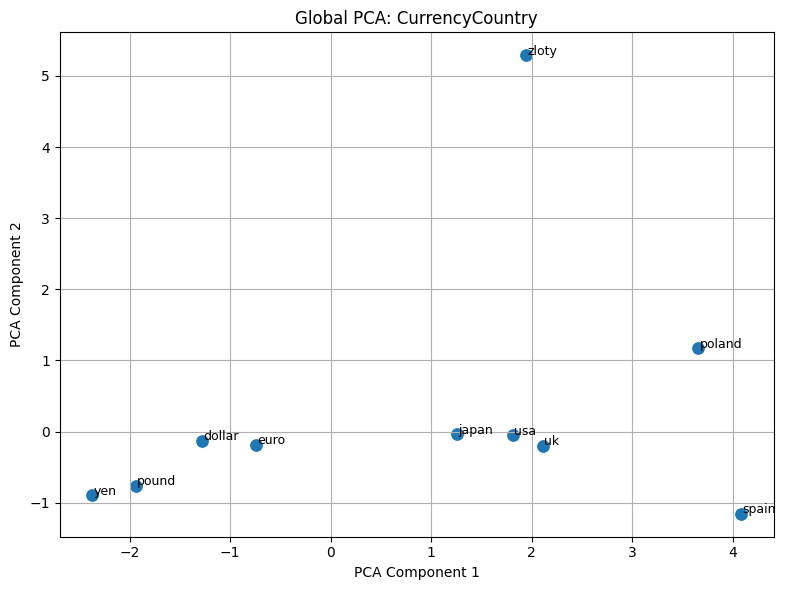

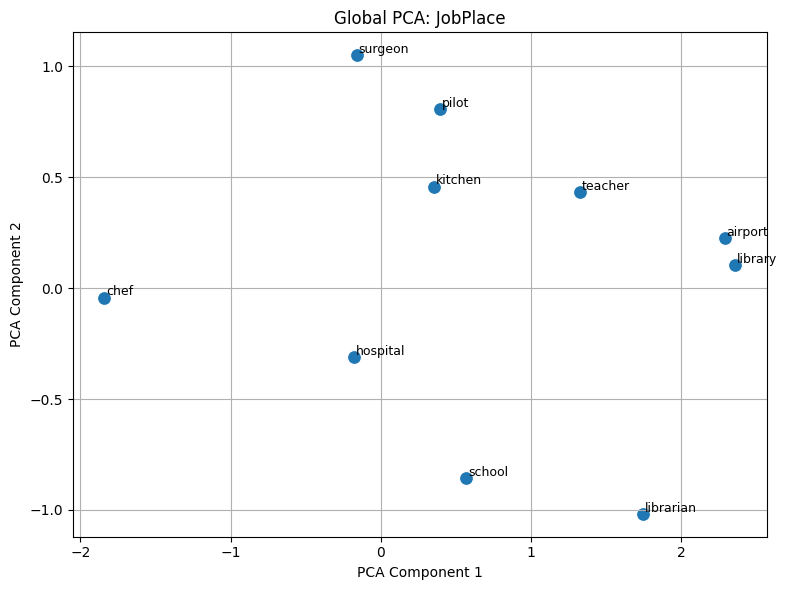

In [3]:
# Global PCA Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(x="x", y="y", hue="class", data=df_all, palette="tab10", s=100)

for _, row in df_all.iterrows():
    plt.text(row["x"] + 0.01, row["y"] + 0.01, row["word"], fontsize=8)

plt.title("Global PCA Projection of Word Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Per-Class PCA Plots using global coordinates
for class_name in semantic_classes.keys():
    df_subset = df_all[df_all["class"] == class_name]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="x", y="y", data=df_subset, color="tab:blue", s=100)

    for _, row in df_subset.iterrows():
        plt.text(row["x"] + 0.01, row["y"] + 0.01, row["word"], fontsize=9)

    plt.title(f"Global PCA: {class_name}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


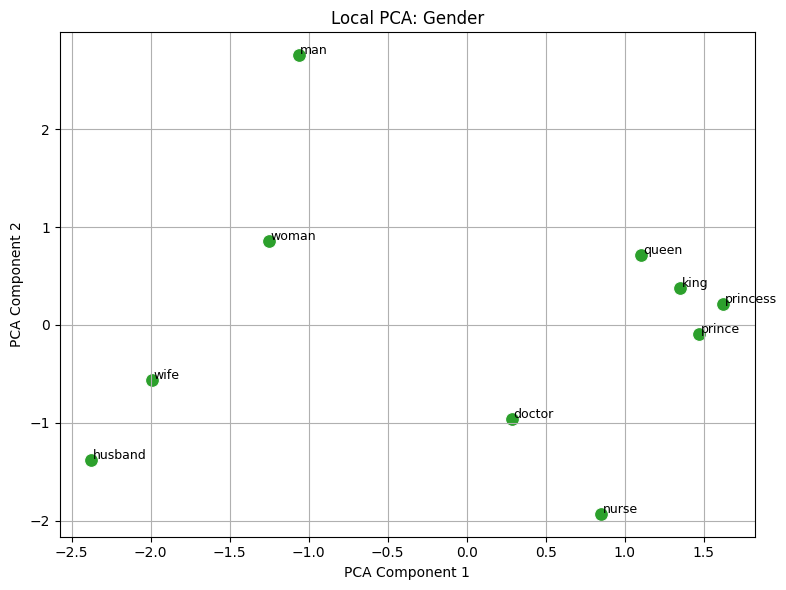

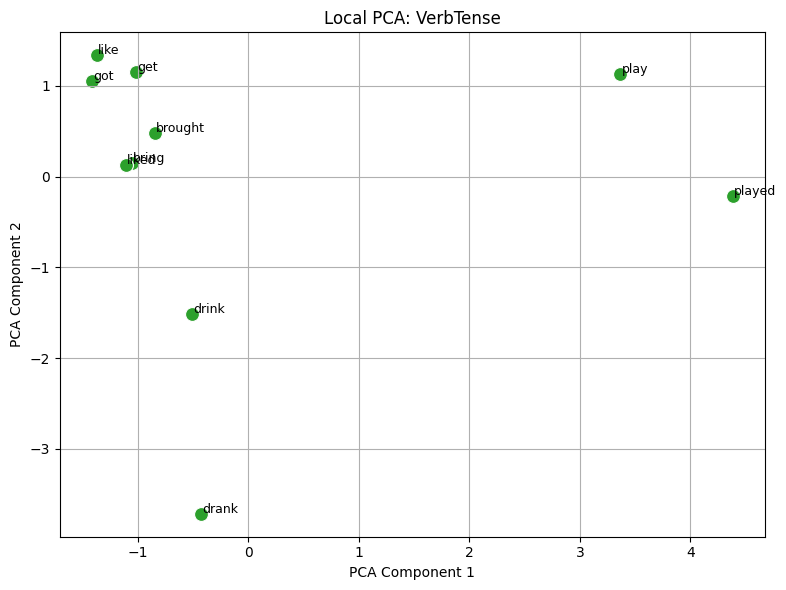

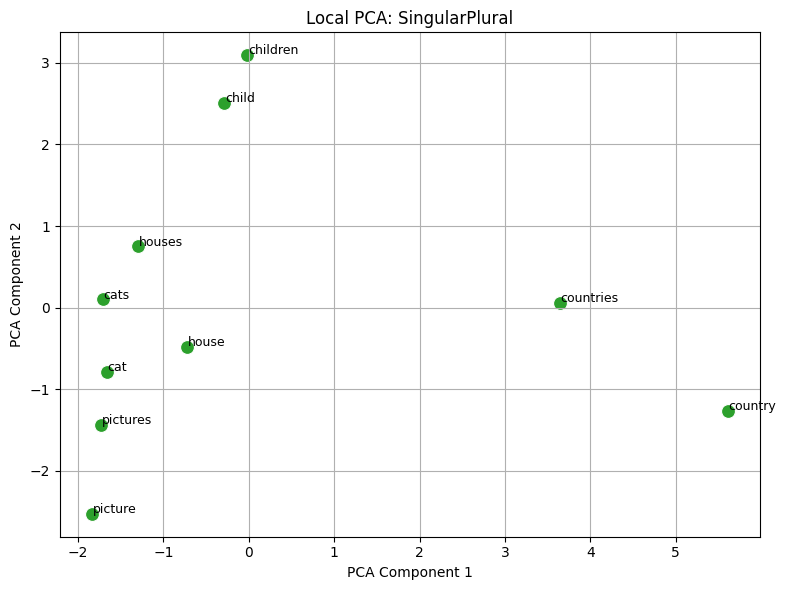

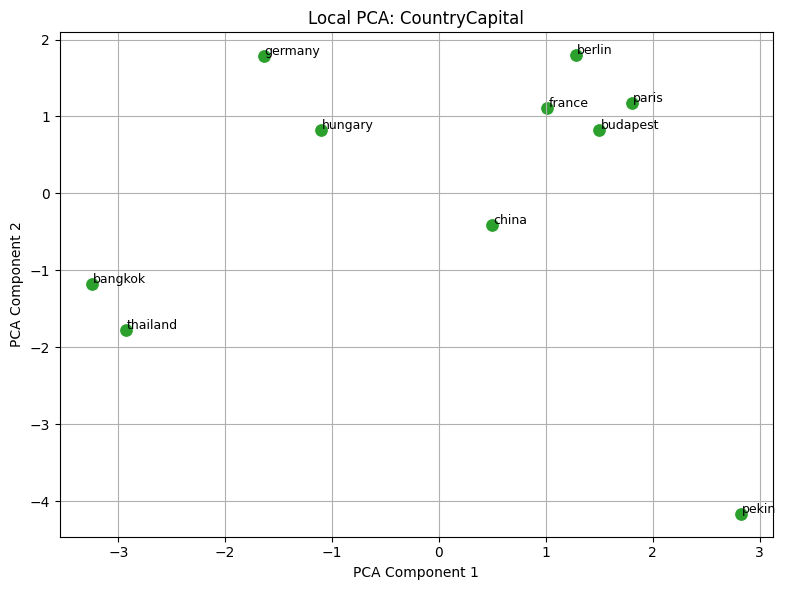

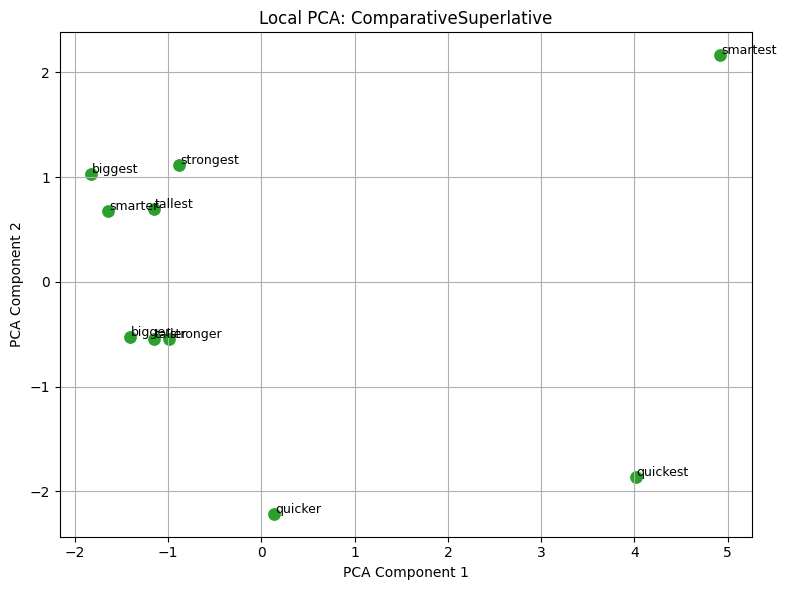

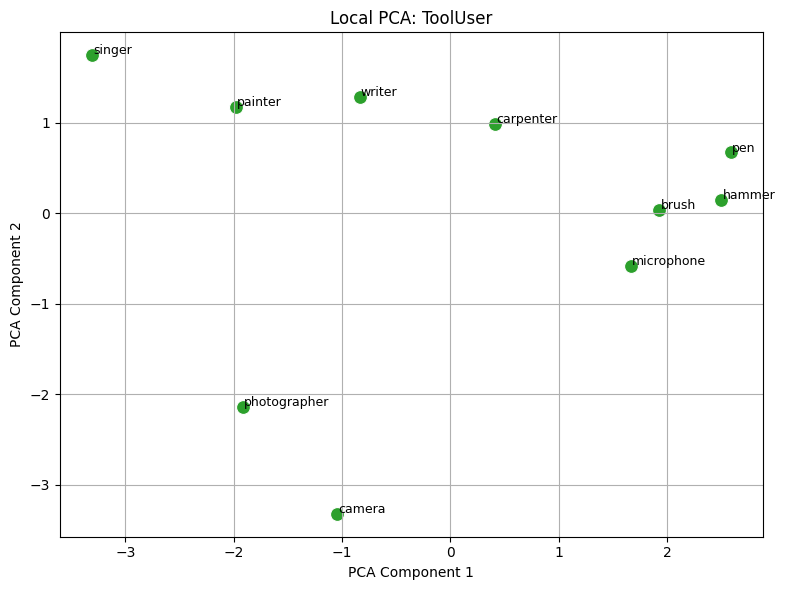

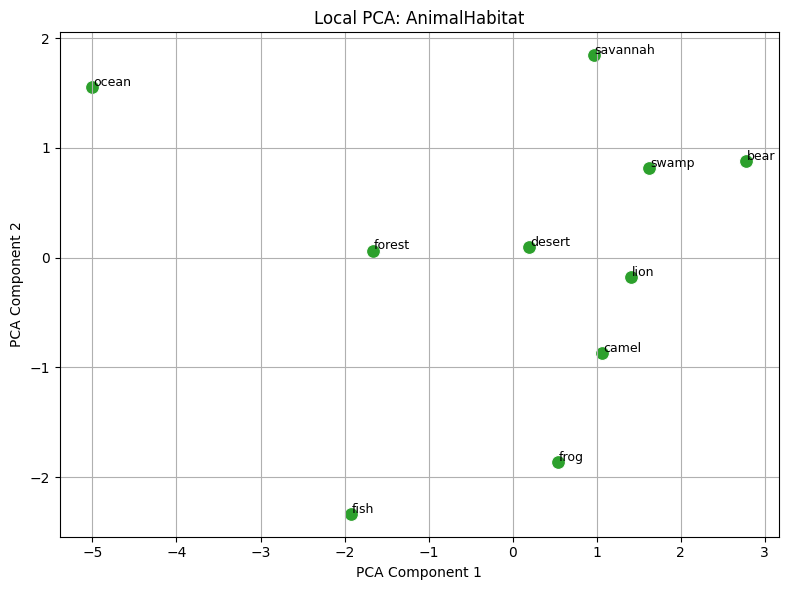

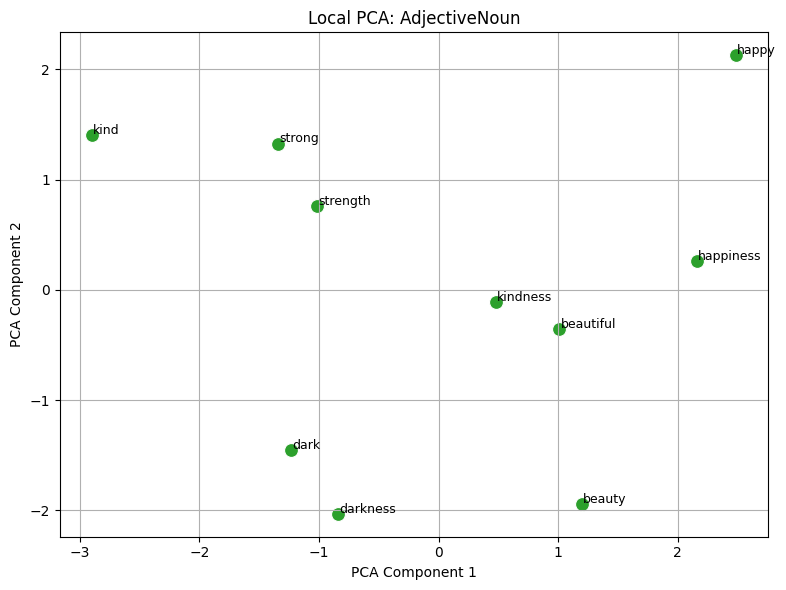

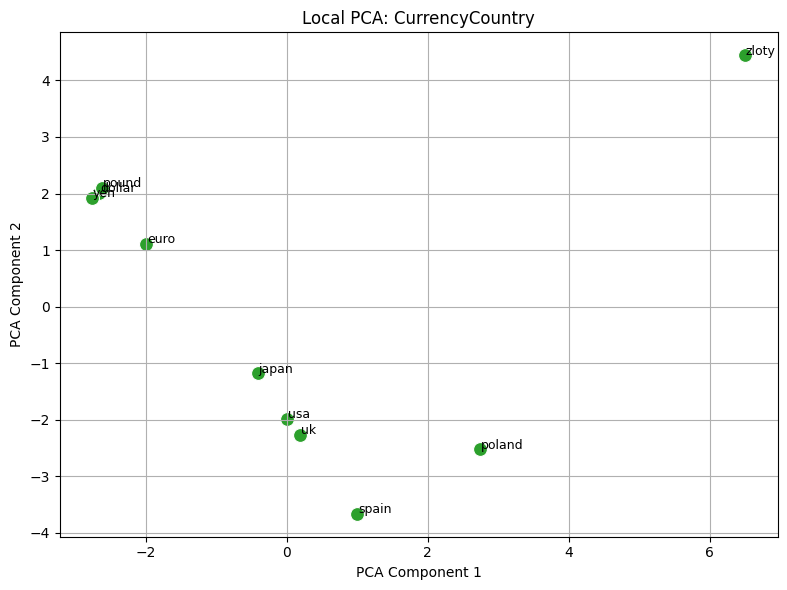

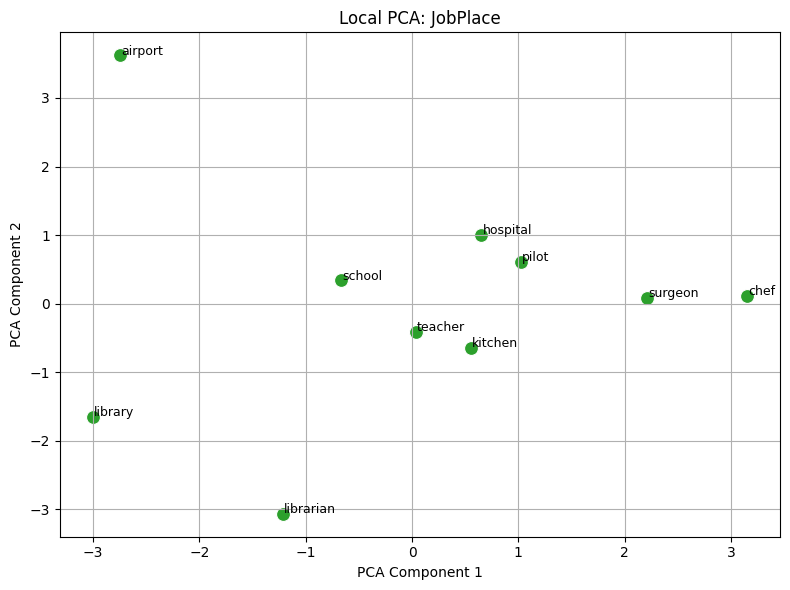

In [5]:
# Local PCA Plot
for class_name, pairs in semantic_classes.items():
    words = sorted(set(word for pair in pairs for word in pair))  # 14 words
    vectors = [embedding_dict[word] for word in words]

    # Apply PCA to this class
    reduced = PCA(n_components=2).fit_transform(vectors)

    # Create DataFrame
    df_class = pd.DataFrame({
        "word": words,
        "x": reduced[:, 0],
        "y": reduced[:, 1]
    })

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="x", y="y", data=df_class, s=100, color="tab:green")

    for _, row in df_class.iterrows():
        plt.text(row["x"] + 0.01, row["y"] + 0.01, row["word"], fontsize=9)

    plt.title(f"Local PCA: {class_name}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Define analogy queries
analogy_queries = {
    "Gender": ("man", "king", "woman"),           # expect ~ queen
    "VerbTense": ("get", "got", "like"),          # expect ~ liked
    "SingularPlural": ("cat", "cats", "child"),     # expect ~ children
    "CountryCapital": ("france", "paris", "germany"),  # expect ~ berlin
    "ComparativeSuperlative": ("biggest", "bigger", "strongest"),  # expect ~ stronger
    "ToolUser": ("pen", "writer", "camera"),      # expect ~ photographer
    "AnimalHabitat": ("fish", "ocean", "camel"),  # expect ~ desert
    "AdjectiveNoun": ("dark", "darkness", "kind"),  # expect ~ kindness
    "CurrencyCountry": ("spain", "euro", "japan"),  # expect ~ yen
    "JobPlace": ("surgeon", "hospital", "teacher")    # expect ~ school
}

# Perform and print analogy results
def print_embedding_arithmetic_results(embedding_dict, queries, top_k=5):
    all_words = list(embedding_dict.keys())
    all_vecs = np.array([embedding_dict[word] for word in all_words])

    for class_name, (a, b, c) in queries.items():
        if not all(w in embedding_dict for w in [a, b, c]):
            print(f"[{class_name}] Missing embedding for one of the words: {a}, {b}, {c}")
            continue

        vec_a = embedding_dict[a]
        vec_b = embedding_dict[b]
        vec_c = embedding_dict[c]
        result_vec = vec_b - vec_a + vec_c

        similarities = cosine_similarity([result_vec], all_vecs)[0]
        candidates = [
            (word, float(sim))
            for word, sim in zip(all_words, similarities)
            if word not in {a, b, c}
        ]
        top_matches = sorted(candidates, key=lambda x: x[1], reverse=True)[:top_k]

        print(f"[{class_name}] {b} - {a} + {c} ≈ ?")
        for i, (word, score) in enumerate(top_matches, 1):
            print(f"  {i}. {word} (cosine similarity: {score:.4f})")
        print()

# Call the function
print_embedding_arithmetic_results(embedding_dict, analogy_queries)

[Gender] king - man + woman ≈ ?
  1. queen (cosine similarity: 0.8644)
  2. princess (cosine similarity: 0.8620)
  3. prince (cosine similarity: 0.8615)
  4. lion (cosine similarity: 0.8428)
  5. wife (cosine similarity: 0.8310)

[VerbTense] got - get + like ≈ ?
  1. liked (cosine similarity: 0.8964)
  2. biggest (cosine similarity: 0.8692)
  3. kind (cosine similarity: 0.8689)
  4. smarter (cosine similarity: 0.8566)
  5. yen (cosine similarity: 0.8543)

[SingularPlural] cats - cat + child ≈ ?
  1. children (cosine similarity: 0.9119)
  2. school (cosine similarity: 0.8087)
  3. teacher (cosine similarity: 0.8052)
  4. fish (cosine similarity: 0.8007)
  5. houses (cosine similarity: 0.7997)

[CountryCapital] paris - france + germany ≈ ?
  1. berlin (cosine similarity: 0.8826)
  2. budapest (cosine similarity: 0.7960)
  3. bangkok (cosine similarity: 0.7888)
  4. librarian (cosine similarity: 0.7772)
  5. hungary (cosine similarity: 0.7611)

[ComparativeSuperlative] bigger - biggest + 

## **Discussion**

### **1.** Interpretation of Plots

Looking at these 21 plots, we can see that global PCA projects all 100 words from different classes onto the same 2D space, which gives an overview of the embedding space but often mixes unrelated concepts, making it harder to identify class-specific patterns. In contrast, local PCA focuses on words within a single semantic class, allowing clearer and more meaningful visualizations. This isolation reduces noise from other classes and reveals the internal structure of relationships with greater precision.

However, this approach does not always work equally well across all classes or word pairs. Some local plots still show overlapping or ambiguous groupings, especially in classes with more abstract or less well-defined relationships.

### Class by Class Analysis
Let's compare the global and local PCA for each class separately:

1. **Gender**
- Global PCA: Some semantic opposites (man/woman, king/queen) are aligned and reasonably close. But doctor/nurse and husband/wife are not clearly distinguishable in gender terms.

- Local PCA: Clearer alignment along gender dimension. Man/woman, husband/wife, king/queen, doctor/nurse are more cleanly separated.

- Local PCA better preserves gender oppositions and analogy structure.

2. **Verb Tense**
- Global PCA: The verb pairs (play/played, bring/brought) are not aligned or close. The variance from other word classes interferes.

- Local PCA: Pairs like like/liked, get/got are more parallel and near each other. drink/drank still shows some distortion.

- Local PCA does a better job showing tense directionality (past vs present) within the verb space.

3. **Singular/Plural**
- Global PCA: Strong alignment for some pairs like cat/cats, house/houses. But country/countries are too far from the others.

- Local PCA: Much more consistent. Pairs cluster together, and the singular-plural direction seems consistent.

- Singular/plural distinctions are clearly preserved in local PCA.

4. **Country/Capital**
- Global PCA: Some pairs (Germany/Berlin, France/Paris) are roughly near each other, but others are scattered.

- Local PCA: Much better clustering. Most capitals are close to their countries. China/Pekin, Hungary/Budapest appear more meaningfully aligned.

- Local PCA is clearly superior, capturing geopolitical relations well.

5. **Comparative/Superlative**
- Global PCA: Mixed results. Some comparatives (stronger/strongest) are near each other, but smartest and quickest are far off.

- Local PCA: Stronger alignment within triplets (bigger/biggest, smarter/smartest), but still some outliers (e.g., quickest).

- This class is noisy. Even locally, PCA struggles to represent clear comparative/superlative lines.

6. **Tool/User**
- Global PCA: Some agent/tool pairs are reasonably close (writer/pen, painter/brush), but overall scattered.

- Local PCA: Stronger separation between tools and users, but not clean vector directions. Camera/photographer stands out.

- Structure is only partially preserved. PCA is weaker for function-based analogies.

7. **Animal/Habitat**
- Global PCA: Semantic coherence is decent. fish/ocean, lion/savannah are close, but some habitats are loosely placed.

- Local PCA: Much better. Animals and their environments cluster meaningfully, showing a clearer animal/habitat separation.

- Local PCA works better here.

8. **Adjective/Noun**
- Global PCA: Some noun/adjective pairs are very close (dark/darkness, beautiful/beauty), others more scattered.

- Local PCA: Almost all adjective/noun transformations appear close and directional (strong/strength, happy/happiness).

- Good local structure. Morphological transformations are well preserved in local PCA.

9. **Currency/Country**
- Global PCA: Many pairs are far apart (zloty/poland, euro/spain), likely because currency words are more abstract.

- Local PCA: Still imperfect, but spatial proximity improves — yen/japan, dollar/usa, zloty/poland are visually closer.

- Currency/country semantics are harder to capture; local PCA helps a bit, but relations remain weak.

10. **Job/Place**
- Global PCA: Reasonable pairings (pilot/airport, librarian/library), though surgeon/hospital is misaligned.

- Local PCA: Much better. Job/place pairs align more clearly. Teacher/school, chef/kitchen are well placed.

- Local PCA captures occupational context better.

### **2.** Are vector relationships preserved?

Yes, in many cases, vector relationships seem to be preserved in the embedding space. This is especially clear in the arithmetic results. For example, gender:
```
king - man + woman ≈ queen
```
shows excellent preservation.

All the examples show the expected results, which indicate that BERT embeddings do encode some meaningful semantic directions. However, some classes like AdjectiveNoun or AnimalHabitat show more noise, with less intuitive top results (e.g., "bigger" and "wife" returned in AdjectiveNoun).

### **3.** Does PCA capture semantic differences?

Yes, but partially. PCA helps to project the embeddings into 2D space, but:

- Global PCA mixes classes, making semantic patterns hard to isolate.

- Local PCA reveals clearer internal structure and separation between words, especially in some classes.

Still, in some classes like Adjective/Noun or Tool/User, PCA does not always separate words meaningfully. Some pairs cluster well, others don't.

### **4.** Are the closest words from the arithmetic meaningful?

In general, yes, particularly for structured semantic relationships. For instance:

- Gender: queen, princess, and wife all appear high on the list.

- VerbTense and Singular/Plural return correct inflected forms (liked, children).

- Currency/Country and Animal/Habitat are less precise, e.g., "japan ≈ euro - spain + yen" works, but "camel ≈ ocean - fish + desert" returns some unrelated words.

This suggests BERT captures syntactic and lexical regularities better than world knowledge or physical associations.

### **5.** What kinds of relationships are captured, and what are not?

Captured well:

- Morphological changes (e.g., tense, plural, comparative/superlative)

- Gender relations (e.g., king/queen, man/woman)

Not captured well:

- Abstract noun derivations (e.g., dark/darkness, happy/happiness)

- Object-function or sound relationships (e.g., pen/writer)

- Some physical/geographic mappings (e.g., fish/ocean, camel/desert)

These weaker relationships likely depend more on world knowledge or contextual cues, which static word-level BERT embeddings don't always encode well.

### **6.** Are some classes better behaved than others?

Yes, as it was explained in the class-by-class analysis, it is clear that some classes work better than others.

In particular, the most well-behaved classes are Gender, VerbTense, Singular/Plural, Comparative/Superlative, and the least consistent ons are Adjective/Noun and Animal/Habitat, which often give unexpected results and noisy plots, suggesting that these relationships are harder for BERT to encode linearly.
